# EuskoFlyx

In this notebook, we are going to implement a simple Content-basedRecommender System for movies, to which end we are going to use the [*movielens* dataset](https://grouplens.org/datasets/movielens/). This dataset contains movie rating data, which has been collected from the [MovieLens web site](https://movielens.org). In particular, we will be used the *movielens-100k* dataset available at *tensorflow-datasets*.

In this lab, we are going to use [*Tensorflow  Recommenders* (TFRS)](https://www.tensorflow.org/recommenders/) to implement a *Collaborative Filtering* algorithm. 



## Install the required libraries

In [3]:
!pip install -q tensorflow_recommenders
!pip install -q --upgrade tensorflow_datasets

     |████████████████████████████████| 85 kB 2.3 MB/s 
     |████████████████████████████████| 462 kB 46.4 MB/s 
     |████████████████████████████████| 4.2 MB 5.2 MB/s 


## Load the required libraries




In [4]:
import pprint

from typing import Dict

import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Dense, Embedding, StringLookup, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow_recommenders.tasks import Ranking
from tensorflow_recommenders.layers.factorized_top_k import BruteForce

from collections import defaultdict

from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt

## Load and inspect the dataset

In [5]:
ratings = tfds.load('movielens/100k-ratings', split = 'train')
movies = tfds.load('movielens/100k-movies', split = 'train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.0.incompleteQ0TWCA/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.0. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/0.1.0.incomplete9NPZSF/movielens-train.tfrecord*...:…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.0. Subsequent calls will reuse this data.


### Display the structure of the dataset

* **Ratings**

In [6]:
for r in ratings.take(1).as_numpy_iterator():
  pprint.pprint(r)

{'bucketized_user_age': 45.0,
 'movie_genres': array([7]),
 'movie_id': b'357',
 'movie_title': b"One Flew Over the Cuckoo's Nest (1975)",
 'raw_user_age': 46.0,
 'timestamp': 879024327,
 'user_gender': True,
 'user_id': b'138',
 'user_occupation_label': 4,
 'user_occupation_text': b'doctor',
 'user_rating': 4.0,
 'user_zip_code': b'53211'}


* **Movies**

In [7]:
for m in movies.take(1).as_numpy_iterator():
  pprint.pprint(m)

{'movie_genres': array([4]),
 'movie_id': b'1681',
 'movie_title': b'You So Crazy (1994)'}


## Filter the information that will be used by the collaborative filtering algorithm

In [8]:
ratings = ratings.map( lambda x: {
    'movie_title': x['movie_title'],
    'user_id': x['user_id'],
    'user_rating': x['user_rating']
})

movies = movies.map(lambda x: x['movie_title'])
unique_users = np.unique(np.concatenate(list(ratings.batch(1_000_000).map(lambda x: x['user_id']))))

### Create user and movie vocabularies

In [9]:
user_vocabulary = StringLookup(mask_token=None)
user_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

# Filmen izenak
movie_vocabulary = StringLookup(mask_token=None)
movie_vocabulary.adapt(movies)

### Print dataset statistics

In [10]:
num_ratings = len(ratings)
num_users = len(unique_users)
num_movies = len(movies)

print(f'Number of ratings:', num_ratings)
print(f'Number of users:', num_users)
print(f'Number of movies:', num_movies)

Number of ratings: 100000
Number of users: 943
Number of movies: 1682


### Print vocabularies

In [11]:
print(user_vocabulary.get_vocabulary())
print(movie_vocabulary.get_vocabulary())

['[UNK]', '405', '655', '13', '450', '276', '416', '537', '303', '234', '393', '181', '279', '429', '846', '7', '94', '682', '308', '92', '293', '222', '201', '59', '435', '378', '880', '417', '896', '592', '796', '758', '561', '130', '406', '551', '334', '804', '268', '474', '889', '269', '727', '399', '642', '916', '145', '650', '363', '151', '524', '749', '194', '387', '90', '648', '291', '864', '311', '747', '85', '286', '327', '653', '328', '385', '299', '497', '95', '271', '457', '18', '301', '532', '374', '805', '178', '1', '389', '870', '716', '883', '833', '472', '437', '313', '533', '881', '280', '339', '504', '184', '788', '894', '666', '314', '506', '932', '886', '798', '244', '343', '707', '606', '454', '109', '373', '354', '782', '62', '345', '790', '487', '207', '622', '892', '407', '588', '500', '774', '660', '312', '305', '711', '43', '535', '919', '854', '456', '618', '200', '102', '49', '495', '87', '6', '851', '868', '60', '256', '643', '452', '144', '843', '807', '

# Build the recommender 

Tensorflow Recommenders (TFRS) is a library for building recommender system models, which helps with the full workflow of building a recommender system: data preparation, model formulation, training, evaluation, and deployment.

Using this library, we will have to implement a *ranking model*, which implements our *model-based collaborative filtering* approach. This model will be used by the recommender.

## Build the ranking model

We will implement a model based on the NCF model proposed in:
[Neural Collaborative Filtering](https://arxiv.org/abs/1708.05031). Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu, Tat-Seng Chua.  WWW, 2017.

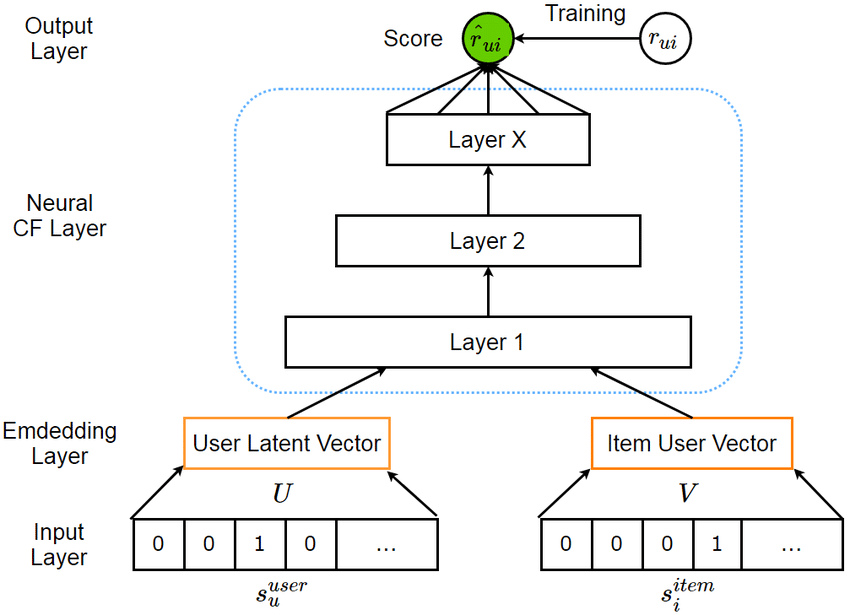


In [19]:
class RankingModel(Model):
  def __init__(self, user_vocabulary, movie_vocabulary, embedding_dimmension=32):
    super().__init__()
    self.user_embeddings = Sequential([user_vocabulary,
                        Embedding(user_vocabulary.vocabulary_size(), embedding_dimmension)])
    self.movie_embeddings = Sequential([movie_vocabulary,
                        Embedding(movie_vocabulary.vocabulary_size(), embedding_dimmension)])
    self.ratings = Sequential([Dense(2*embedding_dimmension, activation='relu'),
                            Dense(64, activation = 'relu'),
                            Dense(16, activation = 'relu'),
                            Dense(1)])

  def call(self, inputs):
    user_id, movie_title = inputs
    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)
    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

## Build the NMF-based model

In [20]:
class EuskoflyxModel(tfrs.models.Model):
  def __init__(self, user_vocabulary, movie_vocabulary,embedding_dimmension):
      super().__init__()
      self.ranking_model: Model = RankingModel(user_vocabulary, movie_vocabulary, embedding_dimmension)
      self.task: Layer = Ranking(
          loss = MeanSquaredError(),
          metrics = [RootMeanSquaredError()]
      )

  def call (self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model((features['user_id'], features['movie_title']))
  
  def compute_loss(self, features: Dict[str, tf.Tensor], training = False) -> tf.Tensor:
    labels = features.pop('user_rating')

    rating_predictions = self(features)

    return self.task(labels = labels, predictions = rating_predictions)

## Train and test the recommender system

In order to train and test the recommender system, we must split the dataset into the *train_set* and the *test_set*. Although *random split* might not be the strategy that best simulates how the recommender systems learns in real contexts, we will use this strategy for simplicity.

### Create the train and test sets

In [21]:
# To obtain replicable results
#tf.random.set_seed(42)

shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
train_cached = train.batch(8192).cache()
test = shuffled.skip(80_000)
test_cached = test.take(20_000).batch(8192).cache()

### Compile the model and evaluate it

Epoch 1/15
10/10 [==============================] - 7s 399ms/step - root_mean_squared_error: 3.6377 - loss: 13.1643 - regularization_loss: 0.0000e+00 - total_loss: 13.1643 - val_root_mean_squared_error: 3.5585 - val_loss: 12.7588 - val_regularization_loss: 0.0000e+00 - val_total_loss: 12.7588
Epoch 2/15
10/10 [==============================] - 0s 31ms/step - root_mean_squared_error: 3.4199 - loss: 11.5634 - regularization_loss: 0.0000e+00 - total_loss: 11.5634 - val_root_mean_squared_error: 3.2202 - val_loss: 10.4587 - val_regularization_loss: 0.0000e+00 - val_total_loss: 10.4587
Epoch 3/15
10/10 [==============================] - 0s 31ms/step - root_mean_squared_error: 2.9103 - loss: 8.2142 - regularization_loss: 0.0000e+00 - total_loss: 8.2142 - val_root_mean_squared_error: 2.3944 - val_loss: 5.8009 - val_regularization_loss: 0.0000e+00 - val_total_loss: 5.8009
Epoch 4/15
10/10 [==============================] - 0s 36ms/step - root_mean_squared_error: 1.8030 - loss: 3.0358 - regulari

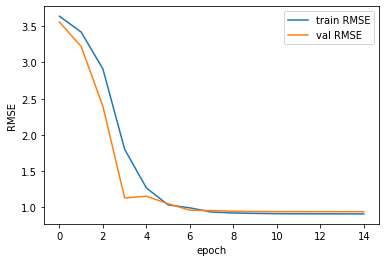

In [22]:
model = EuskoflyxModel(user_vocabulary, movie_vocabulary, embedding_dimmension = 32)
model.compile(optimizer=Adam())

# Can use more epochs and callbacks for early stopping and to keep the best model
history = model.fit(train_cached, epochs=15, validation_data=test_cached)



plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend(['train RMSE', 'val RMSE'])
plt.show()

### Test the ranking model

In order to analyse how the recommender ystem is performing, and considering that we do not know the real user preferences, in  this step, we will compare the recommendations that two users (with different preferences) get.



#### **Compute evaluation metrics**

* **RMSE**

In [23]:
result = model.evaluate(test_cached,return_dict=True)
print(f"RMSE: {result['root_mean_squared_error']}")

3/3 [==============================] - 0s 11ms/step - root_mean_squared_error: 0.9416 - loss: 0.8951 - regularization_loss: 0.0000e+00 - total_loss: 0.8951
RMSE: 0.9416497945785522


* **MPrec**

In [24]:
def getUserMeans(dataset):
    means = dataset.groupby('user_id')['user_rating'].mean()
    userMeans = {}
    for user, meanV in means.items():
        userMeans[user] = meanV
    return userMeans


def getUserLikes(dataset, userMeans):
    userLikedMovies = defaultdict(list)
    for userId, movieId, rating in zip(dataset['user_id'], dataset['movie_title'],dataset['user_rating']):
        if rating > userMeans[userId]:
            userLikedMovies[userId].append(movieId)
    return userLikedMovies

train_dataset = tfds.as_dataframe(train)
test_dataset = tfds.as_dataframe(test)

userLikes = getUserLikes(test_dataset, getUserMeans(train_dataset))


# Set up retrieval using trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.ranking_model.user_embeddings)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.ranking_model.movie_embeddings(title)))
)


hitRates = []
for user in userLikes:
    hits = 0.0
    _, recommendationsForUser = index(np.array([user]))
    for movie in recommendationsForUser[0]:
        if movie in userLikes[user]:
            hits+=1.0
    
    hits/=len(recommendationsForUser)
    hitRates.append(hits*100)
mPrec = np.mean(hitRates)
print(f"MPrec: {mPrec}")

MPrec: 10.942578548212351


#### **Identify two users with very differente tastes**

In [25]:
# This code identifies the two users with lowest similarity (uncomment the code and run it)
#min = [0,0,0]

#for i in range(num_users-1):
#   for j in range(i+1,num_users):
#     a = model.ranking_model.user_embeddings(tf.constant([unique_users[i]]))
#     b = model.ranking_model.user_embeddings(tf.constant([unique_users[j]]))
#     user_similarity = cosine_similarity(a, b)[0][0]

#     if (user_similarity < min[2]):
#       min = [i,j,user_similarity]

min = [340, 585, -0.40689] 


#### **Get the recommendations for the users**

In [29]:

userA = unique_users[min[0]]
userB = unique_users[min[1]]

# Get recommendations.
_, titles = index(np.array([userA]))
print("Recommendations for user {userA}:")
for title in titles[0]:
  print(f"{title}")
print()
_, titles = index(np.array([userB]))
print("Recommendations for user {userB}:")
for title in titles[0]:
  print(f"{title}")
print("=====================================")

Recommendations for user {userA}:
b"Preacher's Wife, The (1996)"
b'Platoon (1986)'
b'Ace Ventura: Pet Detective (1994)'
b'World of Apu, The (Apur Sansar) (1959)'
b'I Know What You Did Last Summer (1997)'
b'Star Trek: First Contact (1996)'
b'Cowboy Way, The (1994)'
b'Roommates (1995)'
b'Candyman (1992)'
b'Batman Returns (1992)'

Recommendations for user {userB}:
b'Con Air (1997)'
b'Crying Game, The (1992)'
b'Sound of Music, The (1965)'
b'Dead Poets Society (1989)'
b'Don Juan DeMarco (1995)'
b'Hoop Dreams (1994)'
b'Wild Bunch, The (1969)'
b'Shall We Dance? (1937)'
b'Faust (1994)'
b'Houseguest (1994)'


# Exercises
The following exercises will allow you to practice on the development of Collaborative Filtering Recommender Systems and the evaluation metrics.

## Computing Mean Reciprocal Rank

The **Mean Reciprocal Rank** tells us, in average, the position in which the first appropriate recommendation appears.

$MRR=\frac{1}{|Q|}\sum^{|Q|}_{i=1}\frac{1}{rank_i}$

where $rank_i$ represents the position of the first acceptable recommendation for the user $i$.

In [30]:
# Compute the MRR
ranks = []
for user in userLikes:
    _, recommendationsForUser = index(np.array([user]))
    for i, movie in enumerate(recommendationsForUser[0]):
        if movie in userLikes[user]:
            ranks.append(1 / (i + 1))
            break

MRR = np.mean(ranks)
print(f"MRR: {MRR}")

MRR: 0.3346437799926172


## Try different model implementations

Analyse how changing the *ranking model* affects the recommendations

* Change the embedding size
* Add or remove hidden layers
* Use the general matrix factorization approach (remove the Neural CF layer and multiply the embeddings in method *call*) 



## Check the performance with a  bigger dataset

Try the *movielens-1m* dataset to analyse if the model can learn more from more ratings.


In [28]:
# Try the model with a bigger dataset
ratings = tfds.load('movielens/1m-ratings', split = 'train')
movies = tfds.load('movielens/1m-movies', split = 'train')